Install

In [1]:
#test
#(studiolab) studio-lab-user@default:~/sagemaker-studiolab-notebooks/AI-OT24$ tensorboard --logdir logs/
!pip install -q ib_insync numpy pandas yfinance matplotlib ta seaborn gymnasium stable-baselines3 sb3-contrib tensorflow scikit-learn quantstats imitation fredapi typing


Import

In [2]:
# Core Libraries
import os
import sys
import time
import datetime
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = info, 2 = warnings, 3 = errors

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Financial Data
import yfinance as yf
import quantstats as qs
import ta

# Machine Learning - Supervised Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Machine Learning - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

# Reinforcement Learning and Environments
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, DQN, HER, PPO, SAC, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
)
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecCheckNan
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib import ARS, MaskablePPO, RecurrentPPO, QRDQN, TRPO

# Imitation Learning
from imitation.algorithms import bc
from imitation.testing.reward_improvement import is_significant_reward_improvement
from imitation.data.types import Transitions

# Interactive Brokers API
from ib_insync import *

from typing import Callable

from collections import Counter

clear_output()


API Fred

In [3]:
from fredapi import Fred
fred = Fred(api_key='xxxxxxxxxxxxxxx')

Function and classes

In [4]:

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [5]:
def sqs_reward_func(reward_temp):
    """Square of reward_temp, with sign preservation."""
    if reward_temp > 0:
        return reward_temp ** 2
    else:
        return -reward_temp ** 2

def sqh_reward_func(reward_temp):
    """Half the square of reward_temp, with sign preservation."""
    if reward_temp > 0:
        return (reward_temp ** 2) / 2
    else:
        return -(reward_temp ** 2) / 2

def smp_reward_func(reward_temp):
    """Increments or decrements reward by 1 based on the sign of reward_temp."""
    if reward_temp > 0:
        return 1
    else:
        return -1

def bin_reward_func(reward_temp):
    """Increments reward by 1 if reward_temp is positive, no penalty otherwise."""
    if reward_temp > 0:
        return 1
    else:
        return 0

def lnr_reward_func(reward_temp):
    """Linear reward, simply returns reward_temp."""
    return reward_temp

def stp_reward_func(reward_temp):
    """Fixed reward increment by 1."""
    return 1

class TradingEnvUnique(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a simple trading environment where the agent must decide whether to
    sell, hold, or buy a financial asset.
    """

    metadata = {"render.modes": ["console", "human"]}

    # Define actions for each stock
    SELL = 0   # Decide to sell the asset
    BUY = 1    # Decide to buy the asset

    LNR = 'LNR'
    SQS = 'SQS'
    SQH = 'SQH'
    SMP = 'SMP'
    BIN = 'BIN'

    def calculate_reward(self, reward_temp):
      # Call the selected reward function
      return self.reward_func(reward_temp)

    def __init__(self, df_unscaled, history_length, reward_type, render_mode="console", buy_com=0.01, sell_com=0.01):
        super().__init__()

        self.reward_func_map = {
        'SQS': sqs_reward_func,
        'SQH': sqh_reward_func,
        'SMP': smp_reward_func,
        'BIN': bin_reward_func,
        'LNR': lnr_reward_func,
        'STP': stp_reward_func
        }

        # Set the reward function based on reward_type, with a default if reward_type is not found
        self.reward_func = self.reward_func_map.get(reward_type, lnr_reward_func)

        self.df_unscaled = df_unscaled
        self.TimeSize = np.shape(df_unscaled)[0]
        self.ColSize = np.shape(df_unscaled)[1]
        self.action_space = spaces.Discrete(2)  # Only 2 actions: SELL and BUY
        self.steps = 0
        self.history_length = history_length
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.history_length*self.ColSize,), dtype=np.float64)
        self.render_mode = render_mode
        self.cashval = 200
        self.shareval = 2
        self.buy_com = buy_com
        self.sell_com = sell_com

        # Initialize portfolio for the stock
        self.portfolio = []
        self.cash = []
        self.shares = []
        cash = self.cashval
        shares = self.shareval
        stock_portfolio = cash + shares * self.df_unscaled['Close'].tolist()[self.history_length]
        self.portfolio.append(stock_portfolio)
        self.cash.append(cash)
        self.shares.append(shares)

        # Initialize action counts
        self.Actions = []
        self.BuyNum = 0
        self.SellNum = 0
        self.rewards = []
        self.sum_rewards = []

    def step(self, action):
        reward = 0
        reward_temp = 0

        # Simulate price change for the stock
        # Perform one step of the environment
        # action: 0 (SELL), 1 (BUY)
        self.Actions.append(action)
        # Simulate price change
        next_close_price = self.df_unscaled['Close'].iloc[self.history_length+self.steps+1]  # Next day's close price
        close_price = self.df_unscaled['Close'].iloc[self.history_length+self.steps]  # Current day's close price

        if action == self.BUY:
            # Perform the buy action at market close price
            self.shares.append(self.shares[-1] + (1 - self.buy_com) * self.cash[-1] / close_price)
            self.cash.append(0)
            # Update portfolio value
            self.portfolio.append(self.cash[-1] + self.shares[-1] * close_price)
            self.BuyNum += 1

            # Calculate the portfolio value at the same day's market close
            reward_temp = 100 * (next_close_price-close_price) / close_price

        elif action == self.SELL:
            # Perform the sell action at market close price
            self.cash.append(self.cash[-1] + (1 - self.sell_com) * self.shares[-1] * close_price)
            self.shares.append(0)
            # Update portfolio value at market open (initially)
            self.portfolio.append(self.cash[-1])
            self.SellNum += 1

            # Calculate the portfolio value at the same day's market close
            reward_temp = -100 * (next_close_price-close_price) / close_price

        reward_temp -= 0.001

        reward_temp = self.calculate_reward(reward_temp)

        reward += reward_temp
        if np.isinf(reward):
            print((next_close_price,close_price,self.steps))
            print(f"{reward_temp} Inf reward detected: {reward}")
            df = self.df[0]
            # Define the column of interest
            column_of_interest = 'Close'

            # Find rows where the value in 'Close' is 0, inf, or NaN
            mask = df[column_of_interest].isin([0, np.inf]) | df[column_of_interest].isna()
            rows_with_conditions = df[mask]

            print(rows_with_conditions)

        # Check if episode is done after a certain number of steps
        self.steps += 1
        done = self.steps >= (self.TimeSize - self.history_length - 1) # -1 for extra day for next_close_price

        observation = np.array(self.df_unscaled.iloc[self.steps:self.steps + self.history_length])
        self.rewards.append(reward_temp)
        if self.sum_rewards == []:
            self.sum_rewards.append(reward_temp)
        else:
            self.sum_rewards.append(self.sum_rewards[-1]+reward_temp)


        return observation.flatten(), reward, done, False, {}

    def reset(self, seed=None, options = None):
        # Reset environment state to initial state
        self.steps = 0
        self.portfolio = []
        self.cash = []
        self.shares = []

        # Reset portfolio for the stock
        cash = self.cashval
        shares = self.shareval
        stock_portfolio = cash + shares * self.df_unscaled['Close'].tolist()[self.history_length]
        self.portfolio.append(stock_portfolio)
        self.cash.append(cash)
        self.shares.append(shares)

        # Reset action counts
        self.Actions = []
        self.BuyNum = 0
        self.SellNum = 0
        self.rewards = []
        self.sum_rewards = []

        observation = np.array(self.df_unscaled.iloc[self.steps:self.steps + self.history_length])

        return observation.flatten(), {}

    def last_observation(self):
        observation = np.array(self.df_unscaled.iloc[-self.history_length:])
        return observation.flatten()

    def render(self, mode='console'):
        """
        Render the environment.
        """
        if mode == "console":
            print(f"Stock price history: {self.portfolio}")
        elif mode == "multiple":
            print(f'Sell: {self.SellNum} Buy: {self.BuyNum}')
            plt.figure(figsize=(10, 6))
            plt.plot(self.df_unscaled['Close'].tolist()[self.history_length:], color='blue', marker='o', label='Stock price')
            for j, val in enumerate(self.Actions):
                if val == 0:
                    plt.plot(j, self.df_unscaled['Close'].tolist()[j+self.history_length], 'ro')  # Red dot
                elif val == 1:
                    plt.plot(j, self.df_unscaled['Close'].tolist()[j+self.history_length], 'go')  # Yellow dot
            plt.plot(self.portfolio, color='black', marker='.', label='Portfolio')
            plt.title(f'Stock price history')
            plt.xlabel('Time step')
            plt.ylabel('Price')
            plt.legend()
            plt.grid()
            plt.show()
        elif mode == "total":
            plt.figure(figsize=(10, 6))
            print(f'Sell: {self.SellNum} Buy: {self.BuyNum}')
            plt.plot(self.df_unscaled['Close'].tolist()[self.history_length:], color='blue', marker='s')
            for j, val in enumerate(self.Actions):
                if val == 0:
                    plt.plot(j, self.df_unscaled['Close'].tolist()[j+self.history_length], 'ro')  # Red dot
                elif val == 1:
                    plt.plot(j, self.df_unscaled['Close'].tolist()[j+self.history_length], 'go')  # Yellow dot

            plt.plot(self.portfolio, color='black', marker='.', label='Portfolio')
            plt.title(f'Portfolio price history')
            plt.xlabel('Time step')
            plt.ylabel('Price')
            plt.legend()
            plt.grid()
            plt.show()
            plt.figure(figsize=(10, 6))
            plt.plot(self.portfolio, color = 'blue', marker = '*', label='Total portfolio')
            plt.title(f'Total Portfolio price history')
            plt.ylim(0,1.2*np.max(self.portfolio))
            plt.xlabel('Time step')
            plt.ylabel('Price')
            plt.legend()
            plt.grid()
            plt.show()

        elif mode == "rewards":
            plt.figure(figsize=(10, 6))
            plt.plot(self.rewards, color='black', marker='.', label='Rewards')
            plt.title(f'Rewards')
            plt.xlabel('Time step')
            plt.ylabel('Reward')
            plt.legend()
            plt.grid()
            plt.show()
            plt.figure(figsize=(10, 6))
            plt.plot(self.sum_rewards, color = 'blue', marker = '*', label='Total rewards')
            plt.title(f'Total Rewards')
            plt.xlabel('Time step')
            plt.ylabel('Reward')
            plt.legend()
            plt.grid()
            plt.show()
            print(f'Total rewards: {sum(self.sum_rewards)}')

    def returns(self):
        returns = 100*(self.portfolio[-1]-self.portfolio[0])/self.portfolio[0]
        print(f'Total return of portfolio: {"{:.2f}".format(returns)}%')

    def returns_num(self):
        returns = 100*(self.portfolio[-1]-self.portfolio[0])/self.portfolio[0]
        return returns

In [6]:
class TradingEnvUniqueMultiple(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a simple trading environment where the agent must decide whether to
    sell, hold, or buy a financial asset.
    """

    metadata = {"render.modes": ["console", "human"]}

    LNR = 'LNR'
    SQS = 'SQS'
    SQH = 'SQH'
    SMP = 'SMP'
    BIN = 'BIN'

    def calculate_reward(self, reward_temp):
      # Call the selected reward function
      return self.reward_func(reward_temp)

    def __init__(self, df_unscaled, history_length, reward_type, render_mode="console", buy_com=0.01, sell_com=0.01):
        super().__init__()

        self.reward_func_map = {
        'SQS': sqs_reward_func,
        'SQH': sqh_reward_func,
        'SMP': smp_reward_func,
        'BIN': bin_reward_func,
        'LNR': lnr_reward_func,
        'STP': stp_reward_func
        }

        # Set the reward function based on reward_type, with a default if reward_type is not found
        self.reward_func = self.reward_func_map.get(reward_type, lnr_reward_func)

        self.df_unscaled = df_unscaled
        self.num_stocks = int(len(df_unscaled.columns.get_level_values('Ticker').unique()))
        self.TimeSize = int(np.shape(df_unscaled)[0])
        self.ColSize = int(len(df_unscaled.iloc[0].index.get_level_values('Price').unique()))
        self.action_space = spaces.Discrete(self.num_stocks+1)  # Only 2 actions: SELL and BUY
        self.steps = 0
        self.history_length = history_length
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.history_length*self.num_stocks*self.ColSize,), dtype=np.float64)
        self.render_mode = render_mode
        self.cashval = 100
        self.shareval = 0
        self.buy_com = buy_com
        self.sell_com = sell_com

        # Initialize portfolio for the stock
        self.portfolio = []
        self.cash = []
        self.shares = []
        cash = self.cashval
        shares = self.shareval
        stock_portfolio = cash
        self.portfolio.append(stock_portfolio)
        self.cash.append(cash)
        self.shares.append(shares)

        # Initialize action counts
        self.Actions = []
        self.rewards = []
        self.sum_rewards = []

    def step(self, action):
        reward = 0
        reward_temp = 0
        sell_price = 0

        self.Actions.append(int(action))
        if action != self.num_stocks: #actions is a stock
            next_close_price = self.df_unscaled.iloc[self.history_length+self.steps]['Close'][self.Actions[-1]] #price of action stock on next day
            close_price = self.df_unscaled.iloc[self.history_length+self.steps-1]['Close'][self.Actions[-1]] #price today of action stock to buy

            cash_today = self.cash[-1]
            if self.steps != 0: #if not first step
                if self.shares[-1] != 0:
                    sell_price = self.df_unscaled.iloc[self.history_length+self.steps-1]['Close'][self.Actions[-2]] #sell price of current stock
                if self.Actions[-1] != self.Actions[-2]: #if different stock than previous
                    cash_today = (self.cash[-1] + (1 - self.sell_com) * self.shares[-1] * sell_price)
                    self.shares.append((1 - self.buy_com) * cash_today / close_price)
                    self.cash.append(0)

            else: #if fist step then only buy
                self.shares.append((1 - self.buy_com) * cash_today / close_price)
                self.cash.append(0)

            self.portfolio.append(self.cash[-1] + self.shares[-1] * close_price)
            reward_temp = 100 * (next_close_price-close_price) / close_price
            
        else: #action is SELL
            cash_today = self.cash[-1]
            if self.steps != 0:
                if self.shares[-1] != 0: #if you have shares
                    sell_price = self.df_unscaled.iloc[self.history_length+self.steps-1]['Close'][self.Actions[-2]]
                    next_close_price = self.df_unscaled.iloc[self.history_length+self.steps]['Close'][self.Actions[-2]]
                    close_price = self.df_unscaled.iloc[self.history_length+self.steps-1]['Close'][self.Actions[-2]]
                    cash_today = (self.cash[-1] + (1 - self.sell_com) * self.shares[-1] * sell_price)
                    self.shares.append(0)
                    self.cash.append(cash_today)
                    self.portfolio.append(self.cash[-1] + self.shares[-1] * close_price)
                    reward_temp = -100 * (next_close_price-close_price) / close_price #negative because is a loss if it goes up and you sold
                else: # if you dont have shares
                    self.portfolio.append(self.portfolio[-1])
                    self.shares.append(self.shares[-1])
                    self.cash.append(self.cash[-1])
                    reward_temp = 0
            else: #if first step then you dont have shares
                self.portfolio.append(self.portfolio[-1])
                self.shares.append(self.shares[-1])
                self.cash.append(self.cash[-1])
        reward_temp -= 100*0.001

        reward_temp = self.calculate_reward(reward_temp)

        reward += reward_temp
        if np.isinf(reward):
            print((next_close_price,close_price,self.steps))
            print(f"{reward_temp} Inf reward detected: {reward}")

        # Check if episode is done after a certain number of steps
        done = self.steps >= (self.TimeSize - self.history_length - 1) # -1 for extra day for next_close_price
        self.steps += 1
        #10 time size
        #5 history
        #[0 1 2 3 4 5 6 7 8 9] time size
        #[0 1 2 3 4] steps
        #[5 6 7 8 9 10] index
        #[4 5 6 7 8 9] df
        #[5 6 7 8 9 10] self.history_length+self.steps close
        #[6 7 8 9 10 11] self.history_length+self.steps+1 nextclose
        #10-5-1 = 4 sum
        #done = 0 >= (10 - 5 - 1) = 4 
        observation = self.df_unscaled.iloc[self.steps:self.steps + self.history_length].values

        self.rewards.append(reward_temp)
        if self.sum_rewards == []:
            self.sum_rewards.append(reward_temp)
        else:
            self.sum_rewards.append(self.sum_rewards[-1]+reward_temp)


        return observation.flatten(), reward, done, False, {}

    def reset(self, seed=None, options = None):
        # Reset environment state to initial state
        self.steps = 0
        self.portfolio = []
        self.cash = []
        self.shares = []

        # Reset portfolio for the stock
        cash = self.cashval
        shares = self.shareval
        stock_portfolio = cash
        self.portfolio.append(stock_portfolio)
        self.cash.append(cash)
        self.shares.append(shares)

        # Reset action counts
        self.Actions = []
        self.rewards = []
        self.sum_rewards = []

        observation = self.df_unscaled.iloc[self.steps:self.steps + self.history_length].values

        return observation.flatten(), {}

    def last_observation(self):
        observation = self.df_unscaled.iloc[-self.history_length:].values
        return observation.flatten()

    def render(self, mode='console'):
        """
        Render the environment.
        """
        if mode == "console":
            print(f"Stock price history: {self.portfolio}")
        elif mode == "multiple":
            print(f'Sell: {self.SellNum} Buy: {self.BuyNum}')
            plt.figure(figsize=(10, 6))
            plt.plot(self.portfolio, color='black', marker='.', label='Portfolio')
            plt.title(f'Stock price history')
            plt.xlabel('Time step')
            plt.ylabel('Price')
            plt.legend()
            plt.grid()
            plt.show()
        elif mode == "total":
            plt.figure(figsize=(10, 6))
            plt.plot(self.portfolio, color = 'blue', marker = '*', label='Total portfolio')
            plt.title(f'Total Portfolio price history')
            plt.ylim(0,1.2*np.max(self.portfolio))
            plt.xlabel('Time step')
            plt.ylabel('Price')
            plt.legend()
            plt.grid()
            plt.show()

        elif mode == "rewards":
            plt.figure(figsize=(10, 6))
            plt.plot(self.rewards, color='black', marker='.', label='Rewards')
            plt.title(f'Rewards')
            plt.xlabel('Time step')
            plt.ylabel('Reward')
            plt.legend()
            plt.grid()
            plt.show()
            plt.figure(figsize=(10, 6))
            plt.plot(self.sum_rewards, color = 'blue', marker = '*', label='Total rewards')
            plt.title(f'Total Rewards')
            plt.xlabel('Time step')
            plt.ylabel('Reward')
            plt.legend()
            plt.grid()
            plt.show()
            print(f'Total rewards: {sum(self.rewards)}')

    def returns(self):
        returns = 100*(self.portfolio[-1]-self.portfolio[0])/self.portfolio[0]
        print(f'Total return of portfolio: {"{:.2f}".format(returns.item())}%')

    def returns_num(self):
        returns = 100*(self.portfolio[-1]-self.portfolio[0])/self.portfolio[0]
        return returns


In [7]:

def create_env_unique(history_length, reward_type, start_date, end_date, stocks, scaler, scalers, pred_dir):
    df = []
    df_unscaled = []
    interval = '1d'
    num_stocks = len(stocks)
    
    # Ensure dates are in datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    start_date_temp = start_date - datetime.timedelta(days=history_length)
    
    # Loop through each stock to download and process data
    for i, stock in enumerate(stocks):
        output_filename = os.path.join(pred_dir, f'{stock}_predictions_{history_length}.csv')
        
        # Download or load data
        if os.path.isfile(output_filename) and os.path.getsize(output_filename) > 0:
            print(f"Loading data for {stock} from {output_filename}")
            data = pd.read_csv(output_filename, index_col=0, parse_dates=True)
            unscaled_data_combined = data.copy()
        else:
            print(f"No data found for {stock}, downloading from Yahoo Finance")
            while True:
                try:
                    data = yf.download(stock, start=start_date_temp, end=end_date, interval=interval, progress=False)
                    if isinstance(data.columns, pd.MultiIndex):
                        data.columns = data.columns.droplevel('Ticker')
                    break
                except Exception as e:
                    print("An error occurred:", e)
                    print("Retrying...")
                    time.sleep(15)

        # Add technical indicators
        data['5MA'] = data['Close'].rolling(window=5).mean()
        data['10MA'] = data['Close'].rolling(window=10).mean()
        data['15MA'] = data['Close'].rolling(window=15).mean()
        data['20MA'] = data['Close'].rolling(window=20).mean()
        data['Daily_Return'] = data['Adj Close'].pct_change() * 100
        data['Bollinger_High'] = ta.volatility.BollingerBands(close=data['Close']).bollinger_hband()
        data['Bollinger_Low'] = ta.volatility.BollingerBands(close=data['Close']).bollinger_lband()
        data['RSI'] = ta.momentum.RSIIndicator(close=data['Close']).rsi()
        
        # Save unscaled data
        unscaled_data_combined = data.copy()

        # Scale data if needed
        if scaler:
            if len(scalers) <= i:
                scalers.append([MinMaxScaler() for _ in range(data.shape[1])])
            data_values = data.values
            data_scaled = np.zeros_like(data_values)
            for col_idx in range(data.shape[1]):
                data_scaled[:, col_idx] = scalers[i][col_idx].fit_transform(data_values[:, col_idx].reshape(-1, 1)).flatten()
            data_combined = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)
        else:
            data_combined = data

        # Assign MultiIndex columns: (Price, Ticker)
        data_combined.columns = pd.MultiIndex.from_product([data.columns, [stock]], names=["Price", "Ticker"])
        unscaled_data_combined.columns = pd.MultiIndex.from_product([unscaled_data_combined.columns, [stock]], names=["Price", "Ticker"])

        # Append to list for later concatenation
        df.append(data_combined)
        df_unscaled.append(unscaled_data_combined)

    # Concatenate all stock data into one DataFrame
    df = pd.concat(df, axis=1)
    df_unscaled = pd.concat(df_unscaled, axis=1)

    # Return the environment setup
    def env_fn():
        return #TradingEnvUnique(df_unscaled, history_length, reward_type)

    #env = TradingEnvUnique(df_unscaled, history_length, reward_type)
    #check_env(env)

    return env, env_fn, df.index, scalers, df, df_unscaled


In [11]:
def create_env(history_length, reward_type, start_date, end_date, stocks, scaler, scalers):
    df = []
    df_unscaled = []
    interval = '1d'
    num_stocks = len(stocks)
    add_date = False

    while True:
        try:
            date_interval = yf.download(stocks[0], start=start_date, end=end_date, interval=interval, progress=False).shape[0]
            if date_interval < 27:
                start_date = (datetime.datetime.strptime(start_date, '%Y-%m-%d') - datetime.timedelta(days=30)).strftime('%Y-%m-%d')
                add_date = True 
            break
        except Exception as e:
            print("An error occurred:", e)
            print("Retrying...")
            time.sleep(5)
      
    if scalers is None:
        scalers = []
    """while True:
        try:
            # Fetch FRED data
            CPI = fred.get_series('MEDCPIM158SFRBCLE', observation_start=start_date)
            M30US = fred.get_series('MORTGAGE30US', observation_start=start_date)
            UNRA = fred.get_series('UNRATE', observation_start=start_date)
            SP500 = fred.get_series('SP500', observation_start=start_date)
            NEWH = fred.get_series('HOUST', observation_start=start_date)
            NASDAQ = fred.get_series('NASDAQCOM', observation_start=start_date)
            CARSA = fred.get_series('TOTALSA', observation_start=start_date)

            fred_df = pd.concat([SP500, CPI, M30US, UNRA, NEWH, NASDAQ, CARSA], axis=1)
            fred_df.columns = ['SP500', 'CPI', 'M30US', 'UNRA', 'NEWH', 'NASDAQ', 'CARSA']

            fred_df = fred_df.bfill()
            fred_df = fred_df.ffill()
        except Exception as e:
            print("An error occurred:", e)
            print("Retrying...")
            time.sleep(15)"""

    data = yf.download(stocks, start=start_date, end=end_date, progress=False)
    
    # Processing each ticker individually
    for ticker in stocks:
        data[('week_day_number', ticker)] = data['Close'][ticker].index.weekday + 1
        data[('5MA', ticker)] = data['Close'][ticker].rolling(window=5).mean()
        data[('10MA', ticker)] = data['Close'][ticker].rolling(window=10).mean()
        data[('15MA', ticker)] = data['Close'][ticker].rolling(window=15).mean()
        data[('20MA', ticker)] = data['Close'][ticker].rolling(window=20).mean()
        data[('Daily_Return', ticker)] = data['Adj Close'][ticker].pct_change() * 100

        # Adding technical indicators
        bollinger = ta.volatility.BollingerBands(close=data['Close'][ticker])
        data[('Bollinger_High', ticker)] = bollinger.bollinger_hband()
        data[('Bollinger_Low', ticker)] = bollinger.bollinger_lband()
        data[('RSI', ticker)] = ta.momentum.RSIIndicator(close=data['Close'][ticker]).rsi()
        macd = ta.trend.MACD(close=data['Close'][ticker])
        data[('MACD', ticker)] = macd.macd()
        data[('MACD_Signal', ticker)] = macd.macd_signal()
        data[('12EMA', ticker)] = ta.trend.EMAIndicator(close=data['Close'][ticker], window=12).ema_indicator()
        data[('26EMA', ticker)] = ta.trend.EMAIndicator(close=data['Close'][ticker], window=26).ema_indicator()
        data[('OBV', ticker)] = ta.volume.OnBalanceVolumeIndicator(close=data['Close'][ticker], volume=data['Volume'][ticker]).on_balance_volume()

    # Backward fill the NaN values after all calculations
    data = data.bfill().ffill() 
    df = data
    df_unscaled = data
    def env_fn():
        return TradingEnvUniqueMultiple(df_unscaled, history_length, reward_type)
    
    env = TradingEnvUniqueMultiple(df_unscaled, history_length, reward_type)
    #check_env(env)
    
    return env, env_fn, date_interval, scalers, df, df_unscaled


In [9]:
def evaluate_best(venv, expert_actions, SEED):
    print("Best")
    i = 0
    best_actions = []
    observation, info = venv.reset(seed=SEED)
    total_reward = 0
    while True:
        # Select action
        action = expert_actions[i]  # Adjust index if needed
        best_actions.append(action)
        # Step the environment
        observation, reward, done, _, _ = venv.step(action)
        total_reward += reward
        i += 1
        if done:
            break
    best_returns = venv.returns()
    venv.render(mode='total')
    venv.render(mode='rewards')
    return best_actions, best_returns, total_reward

def evaluate_buy(venv, SEED):
    print("Buy")
    i = 0
    buy_actions = []
    observation, info = venv.reset(seed=SEED)
    total_reward = 0
    while True:
        action = 1  # Always "Buy"
        buy_actions.append(action)
        observation, reward, done, _, _ = venv.step(action)
        total_reward += reward
        i += 1
        if done:
            break
    buy_returns = venv.returns()
    venv.render(mode='total')
    return buy_actions, buy_returns, total_reward

def evaluate_model(venv, trainer, name, SEED, has_policy=True):
    print(name)
    i = 0
    model_actions = []
    observation, info = venv.reset(seed=SEED)
    total_reward = 0
    while True:
        if has_policy:
            action = trainer.policy.predict(observation, deterministic=True)[0]
        else:
            action = trainer.predict(observation, deterministic=True)[0]
        model_actions.append(action)
        observation, reward, done, _, _ = venv.step(action)
        total_reward += reward
        i += 1
        if done:
            break
    returns = venv.returns()
    venv.render(mode='total')
    venv.render(mode='rewards')
    return model_actions, returns, total_reward

def calculate_accuracy(best_actions, model_actions):
    correct_predictions = sum(1 for best, model in zip(best_actions, model_actions) if best == model)
    accuracy = correct_predictions / len(best_actions) * 100
    return accuracy

def main(venv, expert_actions, sqil_trainer, bc_trainer, learner_gail, learner_airl, SEED):
    best_actions, best_returns, best_total_reward = evaluate_best(venv, expert_actions, SEED)
    buy_actions, buy_returns, buy_total_reward = evaluate_buy(venv, SEED)
    
    sqil_actions, sqil_returns, sqil_total_reward = evaluate_model(venv, sqil_trainer, "SQIL", SEED, has_policy=True)
    bc_actions, bc_returns, bc_total_reward = evaluate_model(venv, bc_trainer, "BC", SEED, has_policy=True)
    gail_actions, gail_returns, gail_total_reward = evaluate_model(venv, learner_gail, "GAIL", SEED, has_policy=False)
    airl_actions, airl_returns, airl_total_reward = evaluate_model(venv, learner_airl, "AIRL", SEED, has_policy=False)
    
    sqil_accuracy = calculate_accuracy(best_actions, sqil_actions)
    bc_accuracy = calculate_accuracy(best_actions, bc_actions)
    gail_accuracy = calculate_accuracy(best_actions, gail_actions)
    airl_accuracy = calculate_accuracy(best_actions, airl_actions)
    buy_accuracy = calculate_accuracy(best_actions, buy_actions)
    
    print(f"SQIL Accuracy: {sqil_accuracy}%")
    print(f"BC Accuracy: {bc_accuracy}%")
    print(f"GAIL Accuracy: {gail_accuracy}%")
    print(f"AIRL Accuracy: {airl_accuracy}%")
    print(f"Buy Accuracy: {buy_accuracy}%")
    
    print(f"SQIL Total Reward: {sqil_total_reward}")
    print(f"BC Total Reward: {bc_total_reward}")
    print(f"GAIL Total Reward: {gail_total_reward}")
    print(f"AIRL Total Reward: {airl_total_reward}")
    print(f"Buy Total Reward: {buy_total_reward}")
    print(f"Best Total Reward: {best_total_reward}")
def evaluate_all(name, model, has_policy, SEED):
    print('Valid')
    evaluate_best(valid_venv,expert_actions_valid,SEED)
    evaluate_buy(valid_venv,SEED)
    evaluate_model(valid_venv,name=name,has_policy=has_policy,SEED=SEED,trainer=model)
    print('Train')
    evaluate_best(train_venv,expert_actions_train,SEED)
    evaluate_buy(train_venv,SEED)
    evaluate_model(train_venv,name=name,has_policy=has_policy,SEED=SEED,trainer=model)
    print('Test')
    evaluate_best(test_venv,expert_actions_test,SEED)
    evaluate_buy(test_venv,SEED)
    evaluate_model(test_venv,name=name,has_policy=has_policy,SEED=SEED,trainer=model)

BC

In [23]:
# Download stock data
start_date = '2020-01-01'
end_date = '2023-06-30'
stocks = ['AAPL','AMZN','META','MSFT','NVDA','TSLA']
env, env_fn, date_interval, scalers, df, df_unscaled = create_env(5, 'SQH', start_date, end_date, stocks, True, [])
check_env(env)
# Create vectorized environment for training
vec_env = make_vec_env(env_fn, n_envs=10, vec_env_cls=SubprocVecEnv)

# Download validation data
valid_start_date = '2023-07-01'
valid_end_date = '2023-12-30'
valid_env, valid_env_fn, _, _, _, _ = create_env(5, 'SQH', valid_start_date, valid_end_date, stocks, True, [])

# Initialize the validation environment
check_env(valid_env)
vec_valid_env = make_vec_env(valid_env_fn, n_envs=1, vec_env_cls=SubprocVecEnv)

test_start_date = '2024-01-01'
test_end_date = '2024-10-30'
test_env, test_env_fn, _, _, _, _ = create_env(5, 'SQH', test_start_date, test_end_date, stocks, True, [])
check_env(test_env)

eval_callback = EvalCallback(
    vec_valid_env,
    n_eval_episodes=1,
    eval_freq=1_000,
    deterministic=True,
    verbose=0,
    best_model_save_path='./models/',
    warn=False,
)


model = PPO("MlpPolicy", vec_env, learning_rate=0.001, n_steps=10, ent_coef=0.10,tensorboard_log='./logs')
#model = A2C("MlpPolicy",
#              vec_env,
#              #policy_kwargs = policy_kwargs,
#              learning_rate=0.0001,
#              ent_coef=0.1,
#              gamma=0.1,
#              n_steps=5,
#              use_sde=False,
#              sde_sample_freq=15,
#              verbose=0,
#              seed=1,
#              tensorboard_log='./logs'
#              )

#model = DQN("MlpPolicy", env, verbose=1, gamma=0,tensorboard_log='./logs')
model.learn(total_timesteps=300_000,log_interval=10_000,tb_log_name=f'A2C_test{0}',callback=eval_callback)

obs, _ = env.reset(seed = 0)

try:
    model = PPO.load('./models/best_model.zip')
    #model = A2C.load('./models/best_model.zip')
except:
    print('No model found')

while True:
    action = model.predict(obs,deterministic=True)[0]
    obs, reward, done, info, _ = env.step(action)
    if done:
        break
env.render(mode='total')
env.render(mode='rewards')
action_counts = Counter(env.Actions)
print("Action Counts:")
print(action_counts)

obs, _ = valid_env.reset(seed = 0)

while True:
    action = model.predict(obs,deterministic=True)[0]
    obs, reward, done, info, _ = valid_env.step(action)
    if done:
        break
valid_env.render(mode='total')
valid_env.render(mode='rewards')
action_counts = Counter(valid_env.Actions)
print("Action Counts:")
print(action_counts)

obs, _ = test_env.reset(seed = 0)

while True:
    action = model.predict(obs,deterministic=True)[0]
    obs, reward, done, info, _ = test_env.step(action)
    if done:
        break
test_env.render(mode='total')
test_env.render(mode='rewards')
action_counts = Counter(test_env.Actions)
print("Action Counts:")
print(action_counts)

#close envs
env.close()
valid_env.close()
test_env.close()

vec_env.close()
vec_valid_env.close()


/tmp/ipykernel_176/1002007884.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_176/1002007884.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_176/1002007884.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_176/1002007884.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent w

KeyboardInterrupt: 

In [12]:
# Set a random seed for reproducibility
SEED = 42

# Download stock data
start_date = '2023-01-01'
end_date = '2023-06-30'
stocks = ['AAPL','AMZN','META','MSFT','NVDA','TSLA']
env, env_fn, date_interval, scalers, df, df_unscaled = create_env(5, 'SQS', start_date, end_date, stocks, True, [])
check_env(env)
# Create vectorized environment for training
vec_env = make_vec_env(env_fn, n_envs=1, vec_env_cls=SubprocVecEnv)

# Download validation data
valid_start_date = '2023-07-01'
valid_end_date = '2023-08-30'
valid_env, valid_env_fn, _, _, _, _ = create_env(5, 'SQS', valid_start_date, valid_end_date, stocks, True, [])

# Initialize the validation environment
check_env(valid_env)
vec_valid_env = make_vec_env(valid_env_fn, n_envs=1, vec_env_cls=SubprocVecEnv)

# Collect Expert Data (Best Trajectories)
expert_obs = []
expert_actions = []

obs, _ = env.reset()
done = False

# Loop to collect expert trajectories based on highest percentage change
while not done:
    # Calculate daily percentage change for each stock to determine the best action
    percentage_changes = np.abs((env.df_unscaled['Close'].pct_change().iloc[env.steps + 5] + 1).fillna(0).values)
    percentage_changes = np.append(percentage_changes, 1)
    
    # Determine the current held position based on the last chosen action
    current_position = expert_actions[-1] if expert_actions else None
    
    # Adjust for commissions: subtract both buy_com and sell_com for all actions except the current position
    adjusted_changes = [
        (change - env.buy_com - env.sell_com) if action != current_position and action != env.num_stocks
        else (change - env.sell_com) if action == env.num_stocks and action != current_position
        else change
        for action, change in enumerate(percentage_changes)
    ]
    
    # Choose the action with the highest adjusted percentage change
    best_action = np.argmax([adjusted_changes])

    # Store the observation and best action
    expert_obs.append(obs)
    expert_actions.append(best_action)
    
    # Take the best action and proceed in the environment
    obs, _, done, _, _ = env.step(best_action)

# Convert expert data to numpy arrays
expert_obs = np.array(expert_obs)
expert_actions = np.array(expert_actions)

# Initialize lists to collect transition data for BC
expert_observations = []
expert_actions_list = []
terminals = []

# Reset the vectorized environment
observation, _ = env.reset(SEED)

# Collect transitions for behavior cloning
for action in expert_actions:
    # Step the environment using the expert action
    next_observation, reward, done, _, _ = env.step(action)

    # Store the observation, action, and done status
    expert_observations.append(observation)
    expert_actions_list.append(action)
    terminals.append(done)

    # Update the current observation
    observation = next_observation
    
    # Reset the environment if the episode is done
    if done:
        observation, _ = env.reset(seed=SEED)

# Convert collected data into Transitions
transitions = Transitions(
    obs=np.array(expert_observations),
    acts=np.array(expert_actions_list),
    next_obs=np.zeros_like(expert_observations),  # Placeholder for next_obs
    dones=np.array(terminals),
    infos=np.array([{}] * len(expert_observations))  # Placeholder for infos
)

BC Learner rewards before training:
Mean reward: 648.3553464816492 +/- 0.00
--------------------------------
| batch_size        | 118      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00195 |
|    entropy        | 1.95     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 129      |
|    loss           | 1.94     |
|    neglogp        | 1.95     |
|    prob_true_act  | 0.143    |
|    samples_so_far | 118      |
--------------------------------
--------------------------------
| batch_size        | 118      |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -0.00148 |
|    entropy        | 1.48     |
|    epoch          | 1000     |
|    l2_loss        | 0        |
|    l2_norm        | 173      |
|    loss           | 1.45     |
|    neglogp        | 1.46     |
|    prob_true_act  | 0.306    |
|    samples_so_far | 118118   |
--------------------------------


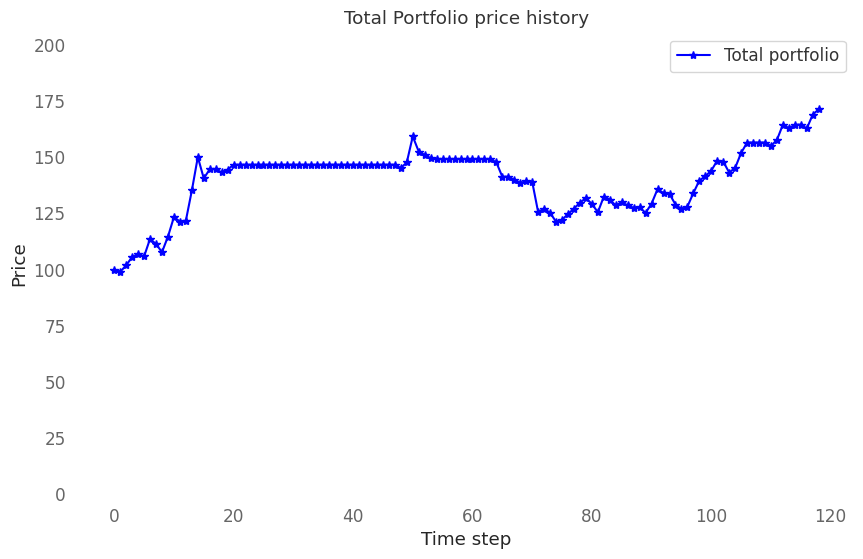

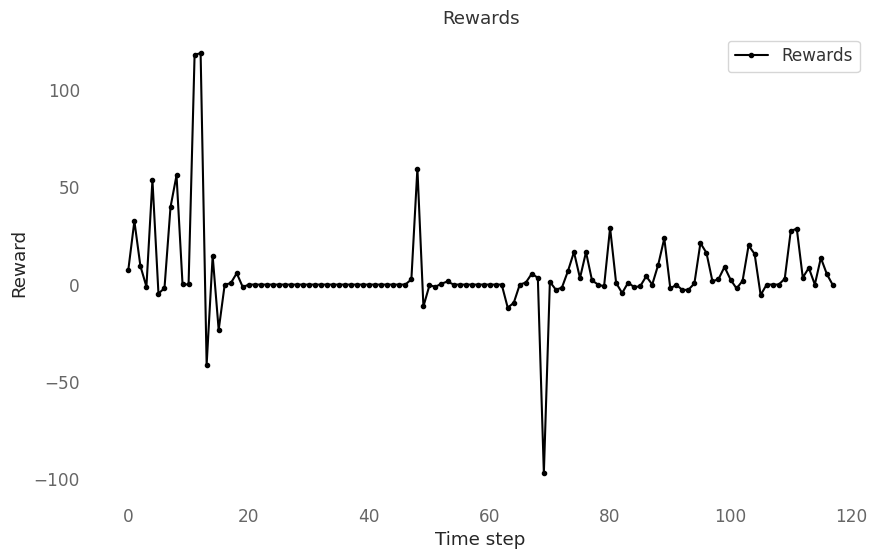

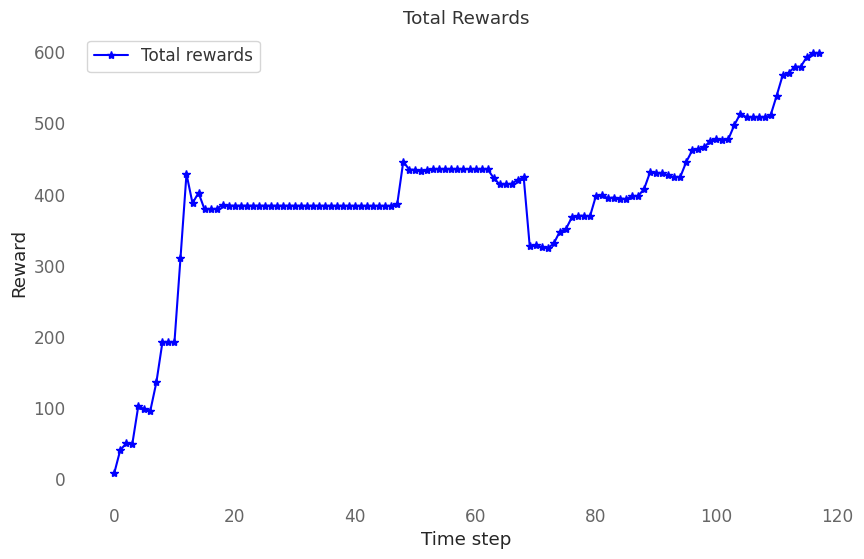

Total rewards: 598.3829532667954
Action Counts:
6    51
5    42
4    20
1     5
Name: count, dtype: int64
BC
Total return of portfolio: -35.28%


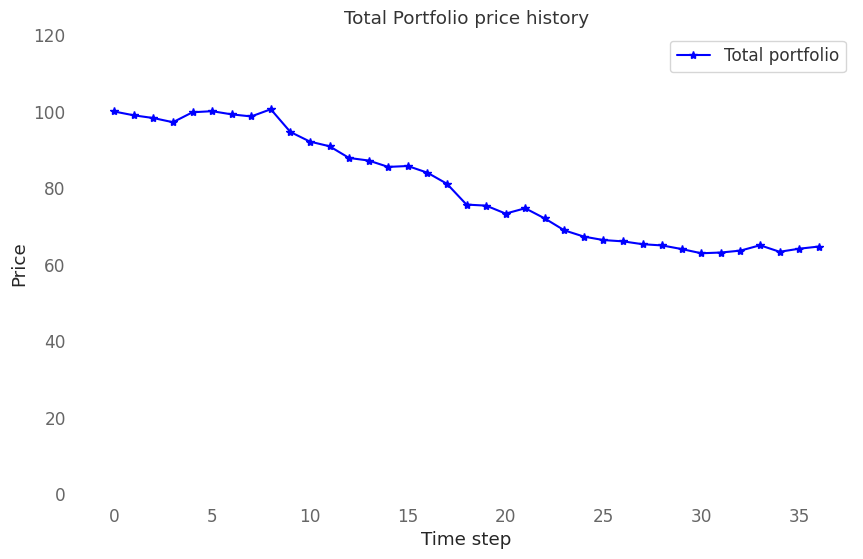

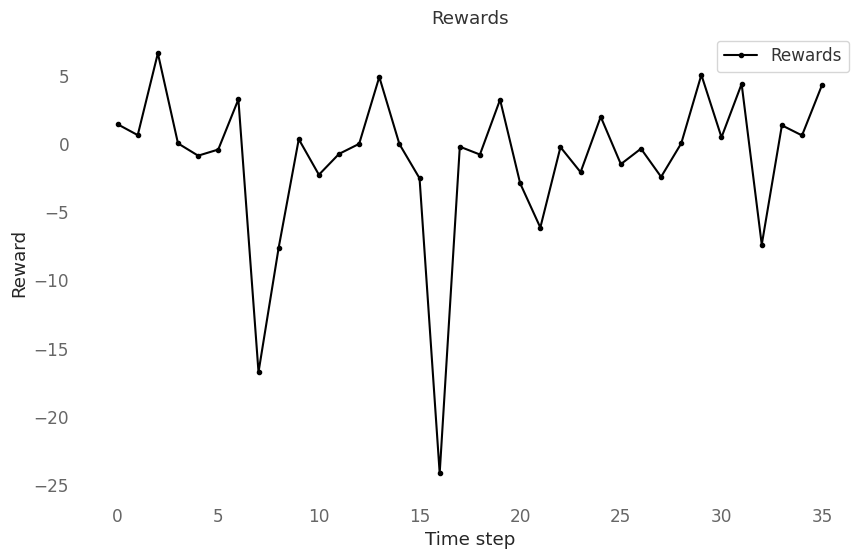

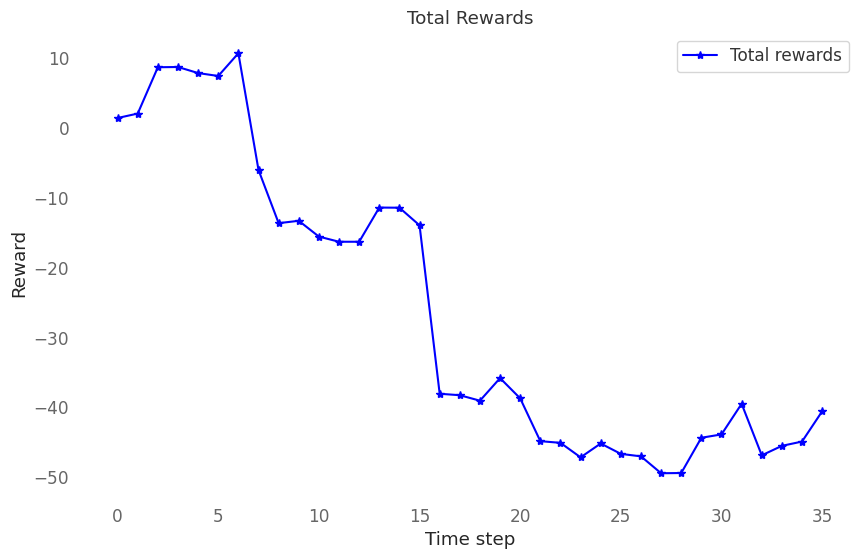

Total rewards: -40.58580009337715
Action Counts:
1    12
0    11
2     6
4     5
5     1
3     1
Name: count, dtype: int64
Best
Total return of portfolio: 1054.23%


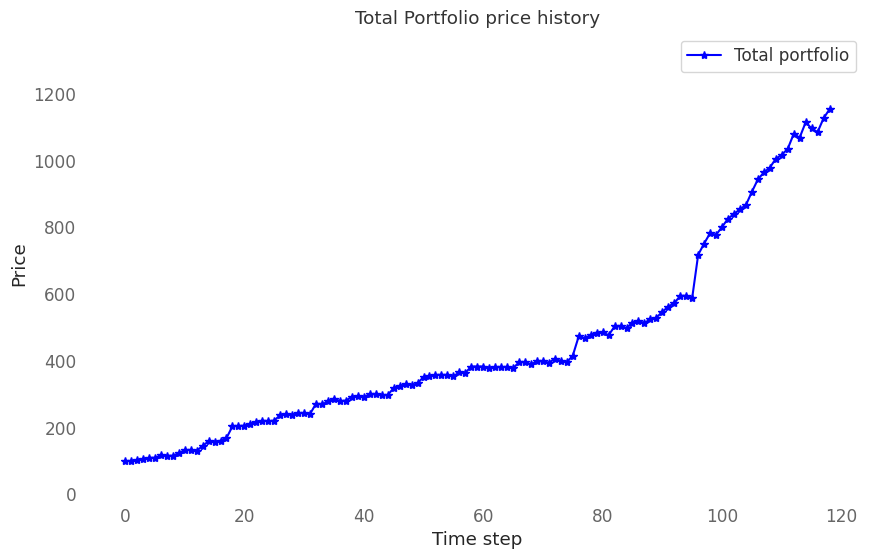

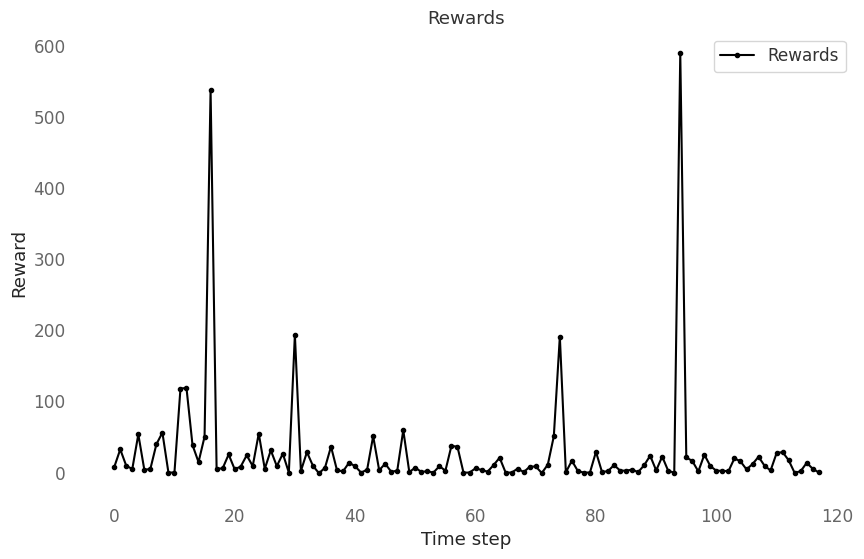

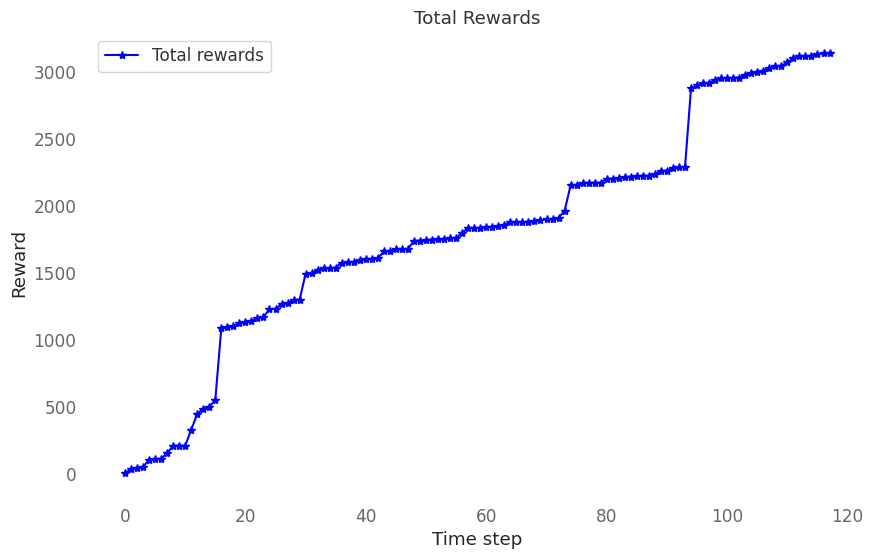

Total rewards: 3139.7045848023267
Action Counts:
5    35
4    24
6    24
1    16
2    10
3     7
0     2
Name: count, dtype: int64


In [26]:
# Initialize the Behavior Cloning (BC) model
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=np.random.default_rng(SEED),
    batch_size=118,
)

# Evaluate the BC policy before training
env.reset(SEED)
mean_reward_bc_before, std_reward_bc_before = evaluate_policy(
    bc_trainer.policy, env, n_eval_episodes=1, return_episode_rewards=False, deterministic=True
)
print("BC Learner rewards before training:")
print(f"Mean reward: {mean_reward_bc_before} +/- {std_reward_bc_before:.2f}")

# Train the BC model with the expert data
bc_trainer.train(
    #n_epochs=100_000,
    n_batches=10_000,
    log_interval=1_000,
    #log_rollouts_n_episodes=10,
    progress_bar=False
)

# Evaluate the BC policy after training
env.reset(SEED)
mean_reward_bc_after, std_reward_bc_after = evaluate_policy(
    bc_trainer.policy, env, n_eval_episodes=1, return_episode_rewards=False, deterministic=True
)
print("BC Learner rewards after training:")
print(f"Mean reward: {mean_reward_bc_after} +/- {std_reward_bc_after:.2f}")

model_actions, returns, total_reward = evaluate_model(env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
model_actions, returns, total_reward = evaluate_model(valid_env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
best_actions, best_returns, total_reward = evaluate_best(env, expert_actions_list, SEED)
action_counts = pd.Series(best_actions).value_counts()
print("Action Counts:")
print(action_counts)

In [10]:
# Close environments
env.close()
valid_env.close()
vec_env.close()
vec_valid_env.close()

KeyboardInterrupt: 

[0.         1.52929424 1.88253569 0.79456    0.04772727 6.65937738]
Total return of portfolio: 61.54%


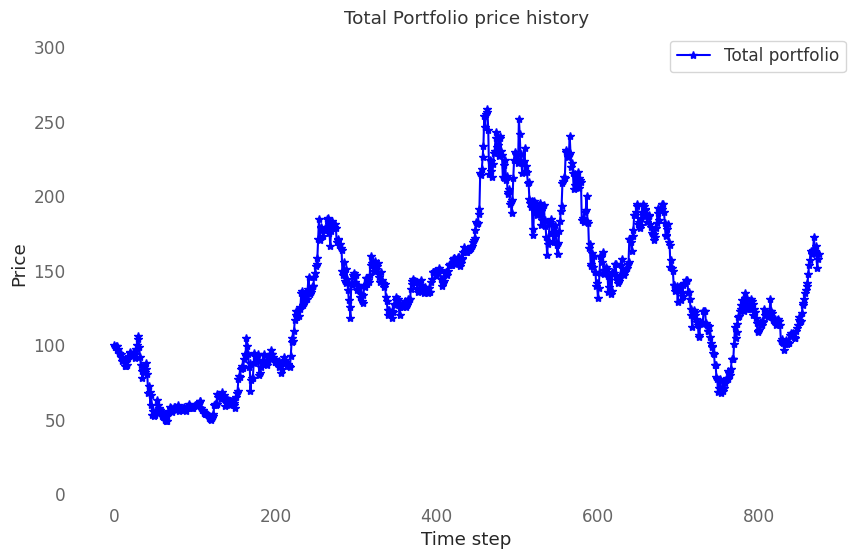

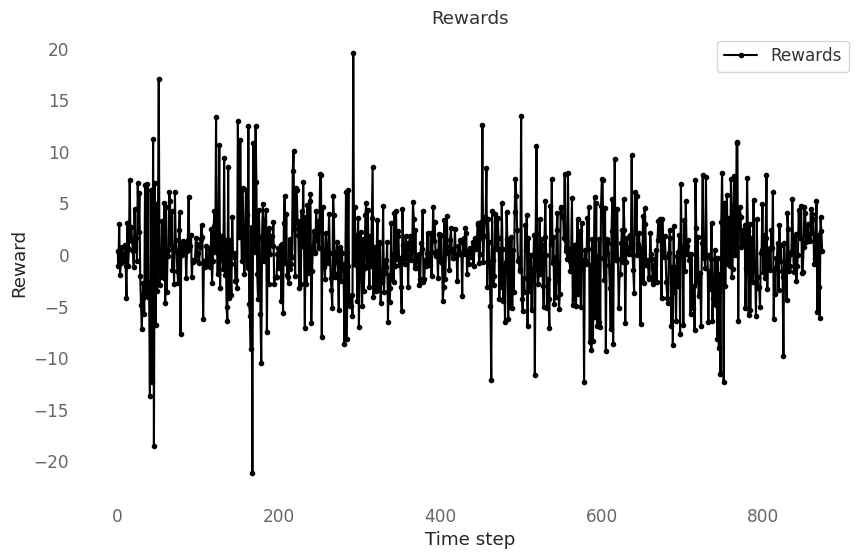

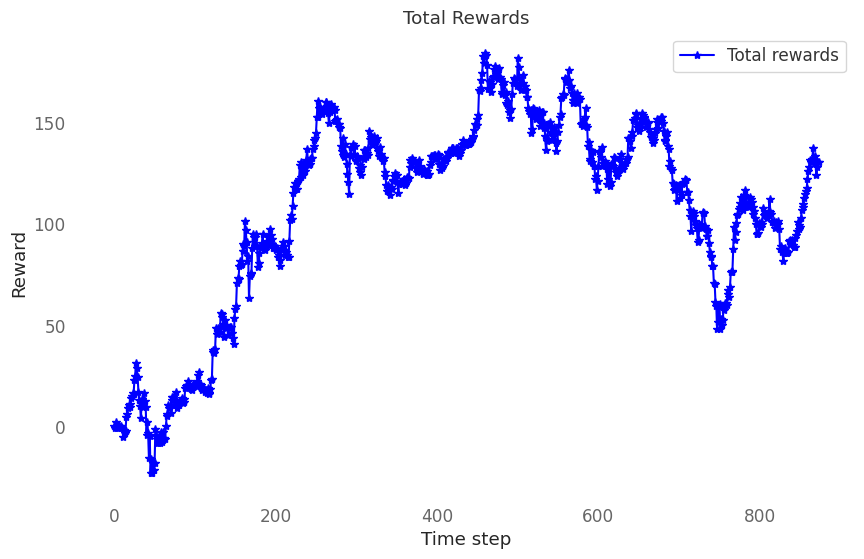

Total rewards: 130.92679714250713


<bound method Env.close of <__main__.TradingEnvUniqueMultiple object at 0x7f791918c340>>

In [17]:
# Download stock data
start_date = '2020-01-01'
end_date = '2023-06-30'
stocks = ['AAPL','AMZN','META','MSFT','NVDA','TSLA']
env, env_fn, date_interval, scalers, df, df_unscaled = create_env(5, 'LNR', start_date, end_date, stocks, True, [])
obs, _ = env.reset()
check_env(env)
obs, _ = env.reset()
percentage_changes = (env.df_unscaled.iloc[100 + 5-1]['Close'].pct_change() + 1).fillna(0).values
print(percentage_changes)
has_policy=True
i = 0
model_actions = []
observation, info = env.reset(seed=42)
total_reward = 0
while True:
    if has_policy:
        action = bc_trainer.policy.predict(observation, deterministic=True)[0]
    else:
        action = bc_trainer.predict(observation, deterministic=True)[0]
    model_actions.append(action)
    observation, reward, done, _, _ = env.step(action)
    total_reward += reward
    i += 1
    if done:
        break
returns = env.returns()
env.render(mode='total')
env.render(mode='rewards')
env.close

RL

Reward Mapping for Each Action Over Days:
     Action_0  Action_1  Action_2  Action_3  Action_4  Action_5
Day                                                            
0    0.126070 -1.041060 -0.209943 -0.562706  0.434932 -0.762730
1    2.036437  0.332258  1.665572  1.102431  3.035236  9.668896
2   -1.450328 -1.255821 -1.384307 -0.804308 -1.965225  2.388282
3   -0.528552 -0.496913  0.854075  0.547621 -0.791530 -3.710201
4    1.152648  0.754991  0.180357  1.732336  1.268247 -1.066248
..        ...       ...       ...       ...       ...       ...
868 -0.271127 -0.730036  1.251448 -1.480590 -1.996576 -3.127089
869 -0.855297 -1.646432 -3.653496 -2.016298 -3.836169 -6.160017
870  1.405907  1.352910  2.981117  1.716799  2.961625  3.700043
871  0.532778 -0.208375 -0.713126  0.282580 -1.912491  2.309969
872  0.079655 -0.983441 -1.417961 -0.338207 -0.817470  0.391730

[873 rows x 6 columns]


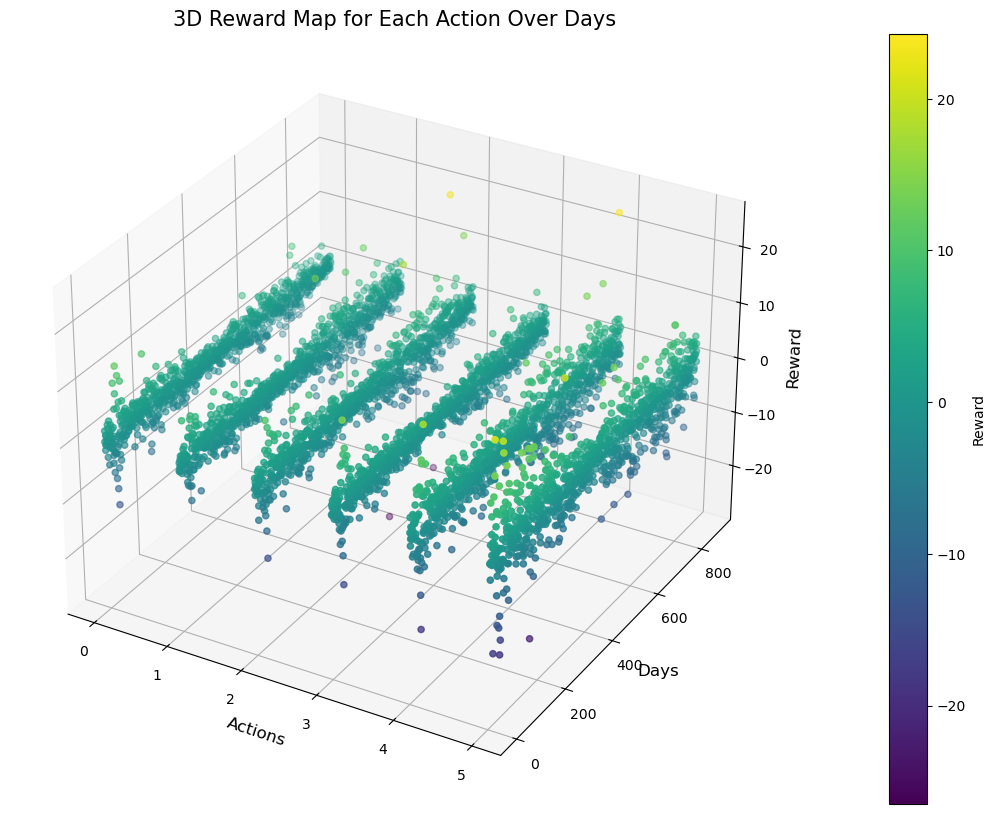

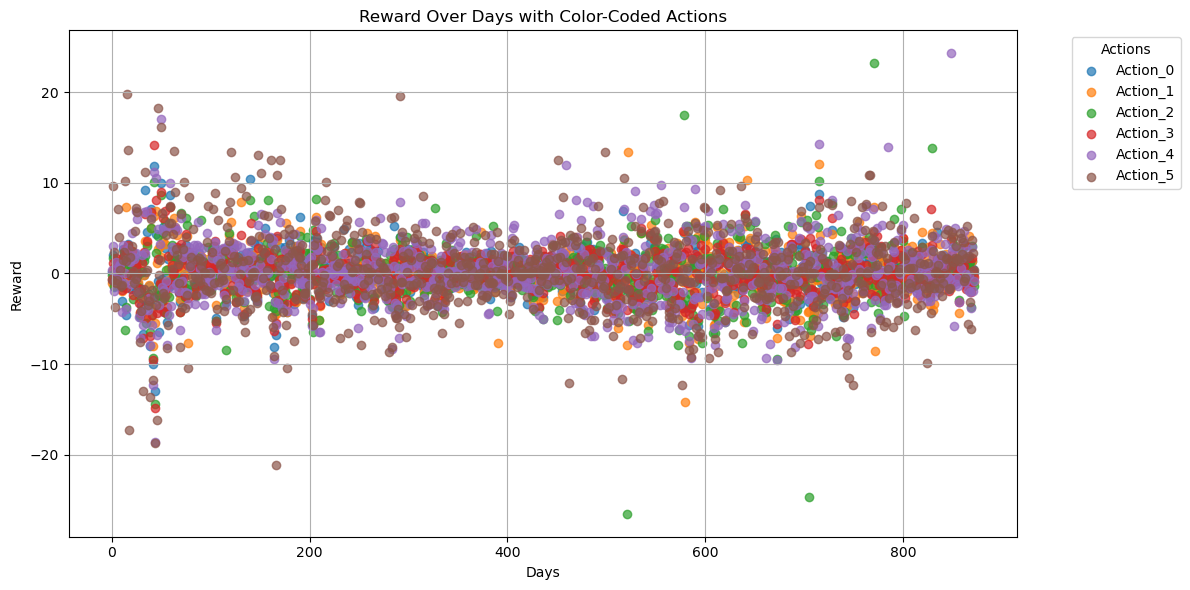

In [22]:
import numpy as np
import pandas as pd
import yfinance as yf
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt

# Download data
start_date = '2020-01-01'
end_date = '2023-06-30'
stocks = ['NVDA', 'AMZN', 'TSLA', 'AAPL', 'MSFT', 'META']
data = yf.download(stocks, start=start_date, end=end_date, interval='1d', progress=False)

# Define environment and model parameters
n_actions = len(stocks)
n_days = data.shape[0]  # Set the number of days to test (modify as needed)

# Initialize reward matrix to store rewards for each action and day
reward_matrix = np.zeros((n_days, n_actions))

# Create the training environment
env = TradingEnvUniqueMultiple(data, 5, 'LNR')
check_env(env)

# Populate reward matrix for each action
for action in range(n_actions):
    obs, _ = env.reset()  # Reset the environment to the beginning of the day
    day = 0
    while True:
        # Take each action and store the reward in the reward matrix
        _, reward, done, _, _ = env.step(action)
        reward_matrix[day, action] = reward
        day+=1
        if done:
            break

# Convert reward matrix to a DataFrame for easier handling and visualization
action_labels = [f"Action_{i}" for i in range(n_actions)]
reward_df = pd.DataFrame(reward_matrix, columns=action_labels)
reward_df.index.name = "Day"

reward_df = reward_df.iloc[:-6]
print("Reward Mapping for Each Action Over Days:")
print(reward_df)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Convert DataFrame to numpy array for easier indexing in 3D plot
reward_array = reward_df.values
days = np.arange(reward_array.shape[0])  # Number of days
actions = np.arange(reward_array.shape[1])  # Number of actions

# Create a meshgrid for days and actions to plot in 3D
days_mesh, actions_mesh = np.meshgrid(days, actions)

# Plot in 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Flatten the meshgrid and reward matrix for 3D plotting
x = actions_mesh.flatten()
y = days_mesh.flatten()
z = reward_array.T.flatten()  # Transpose reward_array to align with x and y

# Create a scatter plot
sc = ax.scatter(x, y, z, c=z, cmap="viridis", marker='o')

# Add color bar to indicate reward values
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Reward')

# Set labels
ax.set_xlabel("Actions", fontsize=12)
ax.set_ylabel("Days", fontsize=12)
ax.set_zlabel("Reward", fontsize=12)
ax.set_title("3D Reward Map for Each Action Over Days", fontsize=15)

plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Assuming reward_df_trimmed is the DataFrame with reward data after removing the last 6 rows
days = np.arange(reward_df.shape[0])  # Array of days
n_actions = reward_df.shape[1]        # Number of actions

# Plot each action as a separate color
plt.figure(figsize=(12, 6))
for action_index, action_name in enumerate(reward_df.columns):
    plt.scatter(days, reward_df[action_name], label=action_name, alpha=0.7)

# Customize the plot
plt.title("Reward Over Days with Color-Coded Actions")
plt.xlabel("Days")
plt.ylabel("Reward")
plt.legend(title="Actions", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


No data found for NVDA in /stocks_data/NVDA_predictions_5.csv
No data found for NVDA in /stocks_data/NVDA_predictions_5.csv
Eval num_timesteps=10000, episode_reward=117.80 +/- 0.00
Episode length: 146.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=117.80 +/- 0.00
Episode length: 146.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=117.80 +/- 0.00
Episode length: 146.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-118.85 +/- 0.00
Episode length: 146.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=117.80 +/- 0.00
Episode length: 146.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=117.80 +/- 0.00
Episode length: 146.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=117.80 +/- 0.00
Episode length: 146.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=97.95 +/- 0.00
Episode length: 146.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=130.08 +/- 0.00
Episode length: 146.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, epis

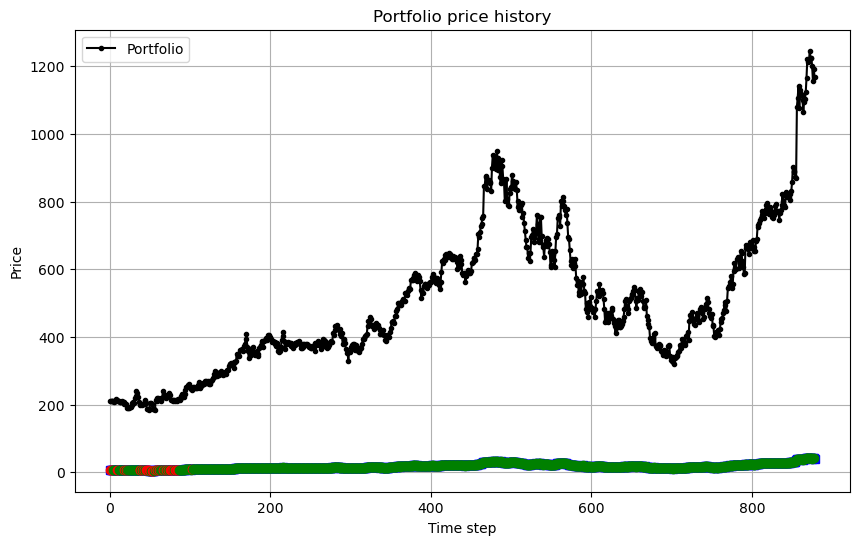

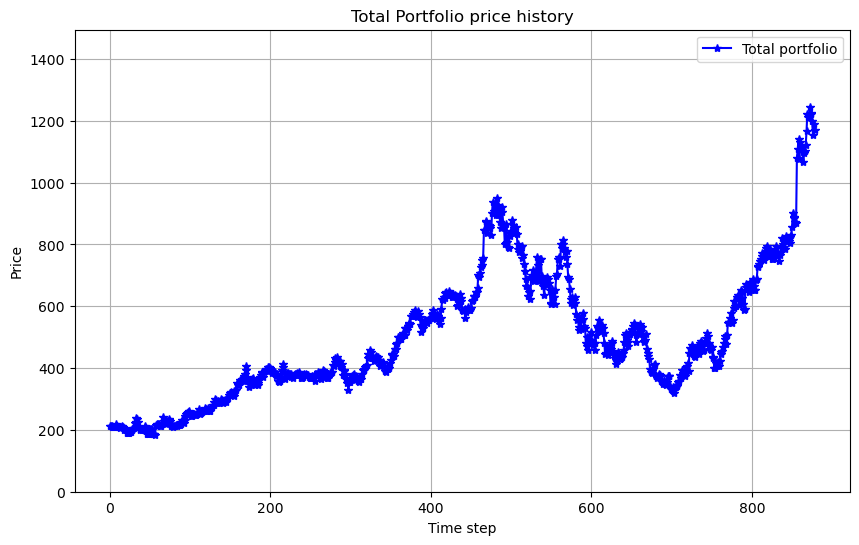

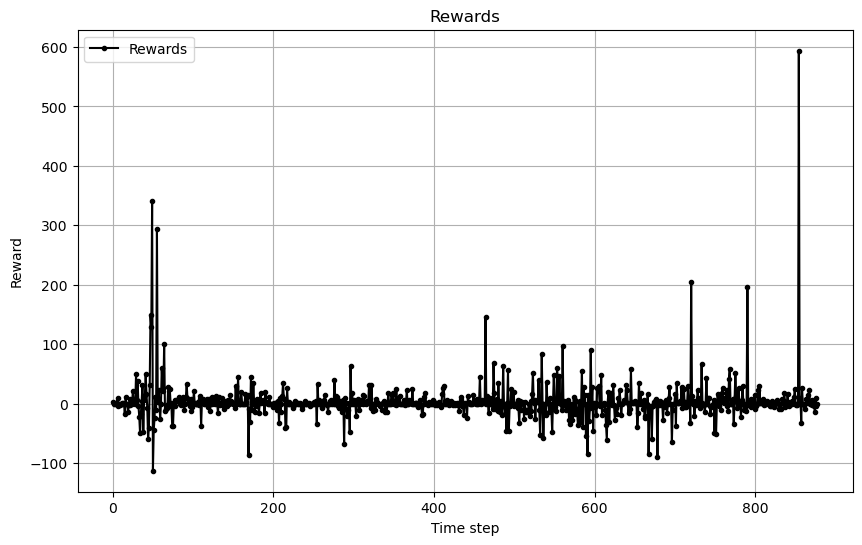

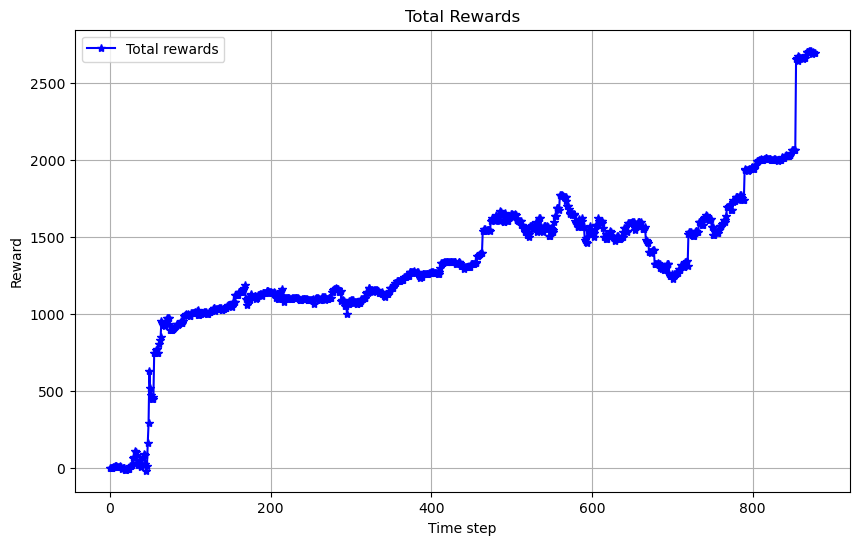

Total rewards: 1164031.5445157974
No data found for AMZN in /stocks_data/AMZN_predictions_5.csv
Eval num_timesteps=110000, episode_reward=-169.67 +/- 0.00
Episode length: 146.00 +/- 0.00


In [ ]:
#df = yf.download("NVDA",'2020-01-01', '2020-06-01')
stocks = ["NVDA"]
start_date = '2020-01-01'
end_date = '2023-06-30'
start_date_test = '2023-06-01'
end_date_test = '2023-12-30'
env, env_fn, date_interval, scalers, df, df_unscaled = create_env_unique(5, 'SQS', start_date, end_date, stocks, True, [], '/stocks_data')
_, valid_env_fn, _, _, _, _ = create_env_unique(5, 'SQS', start_date_test, end_date_test, stocks, True, [], '/stocks_data')
#env = TradingEnvUnique(df_unscaled=df, history_length=5, reward_type='LNR')
check_env(env)
vec_env = make_vec_env(env_fn, n_envs=10, vec_env_cls=SubprocVecEnv)
vec_valid_env = make_vec_env(valid_env_fn, n_envs=1, vec_env_cls=SubprocVecEnv)

"""
stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback = EvalCallback(eval_env, eval_freq=1000, callback_after_eval=stop_train_callback, verbose=1)
"""

# Evaluation callback
eval_callback = EvalCallback(
    vec_valid_env,
    n_eval_episodes=1,
    eval_freq=1_000,
    deterministic=True,
    verbose=1,
    best_model_save_path='./models/',
    warn=True,

)

model = A2C("MlpPolicy",
              vec_env,
              #policy_kwargs = policy_kwargs,
              learning_rate=0.005,
              ent_coef=0.1,
              gamma=0,
              n_steps=1,
              use_sde=False,
              sde_sample_freq=15,
              verbose=0,
              seed=1,
              tensorboard_log='./logs'
              )
stocks = ['AMZN','TSLA','AAPL','MSFT','META']
for i in range(6):
    if i == 0:
        model.learn(total_timesteps=100_000,log_interval=10_000,tb_log_name=f'A2C_test{i}', callback=eval_callback)
        vec_env.close()
    else:
        _, env_fn, _, _, _, _ = create_env_unique(5, 'SQS', start_date, end_date, [stocks[i-1]], True, [], '/stocks_data')
        vec_env=(make_vec_env(env_fn, n_envs=10, vec_env_cls=SubprocVecEnv))
        model.set_env(vec_env)
        model.learn(total_timesteps=100_000,log_interval=1_000,tb_log_name=f'A2C_test{i}',reset_num_timesteps=False, callback=eval_callback)
        vec_env.close()
    obs, _ = env.reset(seed = 0)

    while True:
        action, _ = model.predict(obs,deterministic=True)
        obs, reward, done, info, _ = env.step(action)
        if done:
            break
    env.render(mode='total')
    env.render(mode='rewards')

In [ ]:
stocks = ["NVDA"]
start_date = '2024-01-01'
end_date = '2024-06-30'
env, env_fn, date_interval, scalers, df, df_unscaled = create_env_unique(5, 'SQS', start_date, end_date, stocks, True, [], '/stocks_data')
#env = TradingEnvUnique(df_unscaled=df, history_length=5, reward_type='LNR')
check_env(env)
#vec_env = make_vec_env(env, n_envs=10, vec_env_cls=SubprocVecEnv)
obs, _ = env.reset(seed = 0)
try:
    model = A2C.load('./models/best_model.zip')
except:
    print('No model found')

while True:
    action, _ = model.predict(obs,deterministic=True)
    obs, reward, done, info, _ = env.step(action)
    if done:
        break
env.render(mode='total')
env.render(mode='rewards')